In [1]:
import numpy as np
import pandas as pd
import os

os.chdir(os.getcwd().rsplit('/',1)[0])

# nominate columns
col_tar = ['beer_style']
col_num = ['review_aroma', 'review_appearance', 'review_palate', 'review_taste']

filepath = 'data/processed/beer_review_cleaned.csv'

# load data from csv
df = pd.read_csv('data/raw/beer_reviews.csv')

# clean up dataset: drop unrelated columns and drop rows that contain NA 
df_cleaned = df.copy()
df_cleaned = df[col_num + col_tar]

# store data
df_cleaned.dropna(inplace=True)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
df_cleanedx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117586 entries, 257 to 1586564
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   review_aroma       117586 non-null  float64
 1   review_appearance  117586 non-null  float64
 2   review_palate      117586 non-null  float64
 3   review_taste       117586 non-null  float64
 4   beer_style         117586 non-null  object 
dtypes: float64(4), object(1)
memory usage: 10.4+ MB


In [4]:
df_cleanedx = df_cleaned.copy()
df_cleanedx = df_cleanedx[df_cleanedx['beer_style']=='American IPA']

In [7]:
target = df_cleanedx.pop('beer_style')
target.value_counts()

American IPA    117586
Name: beer_style, dtype: int64

In [9]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
enc = LabelEncoder()
enc_target = np.array(target)
enc_target = enc.fit_transform(target)

sc = StandardScaler()
df_scaled = sc.fit_transform(df_cleanedx)
df_scaled.shape

(117586, 4)

In [11]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(df_scaled, enc_target, stratify=enc_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, stratify=y_data, test_size=0.15, random_state=42)

In [12]:
from src.models.pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

In [15]:
from src.models.pytorch import PytorchMCxlayers
from src.models.pytorch import train_classification, test_classification
from src.models.pytorch import get_device
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from src.models.train_model import model_test_case

def train_model(lr=0.01, neus=256, epochs=3, batch_size=16):    
    
    print(f'=========== learning rate: {lr}, hidden layer neurons: {neus} ============')
    model = PytorchMCxlayers(X_train.shape[1], hlayer_neurons=neus)
    
    device = get_device()
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    N_EPOCHS = epochs
    BATCH_SIZE = batch_size

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    for epoch in range(N_EPOCHS):
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()

        train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
        valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

        print(f'Epoch: {epoch}')
        print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
        print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        end.record()

        # Waits for everything to finish running
        torch.cuda.synchronize()

        # convert milisecond into minutes
        timecost = round(start.elapsed_time(end)/1000/60, 2)
        print(f'Time taken for this epoch = {timecost} minutes. \n')
        
    epoch_count = range(1, len(train_accs)+1)

    plt.plot(epoch_count, train_accs, 'r--')
    plt.plot(epoch_count, valid_accs, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.show()
    
    model_test_case(model=model, aroma=33, appearance=18, palate=46, taste=41, device=device)
    
    return model

=========== learning rate: 1e-05, hidden layer neurons: 256 ============
Epoch: 0
	(train)	|	Loss: 0.3348	|	Acc: 65.8%
	(valid)	|	Loss: 0.3043	|	Acc: 100.0%
Time taken for this epoch = 0.17 minutes. 

Epoch: 1
	(train)	|	Loss: 0.3064	|	Acc: 75.0%
	(valid)	|	Loss: 0.2860	|	Acc: 100.0%
Time taken for this epoch = 0.17 minutes. 

Epoch: 2
	(train)	|	Loss: 0.3006	|	Acc: 75.1%
	(valid)	|	Loss: 0.2846	|	Acc: 100.0%
Time taken for this epoch = 0.17 minutes. 



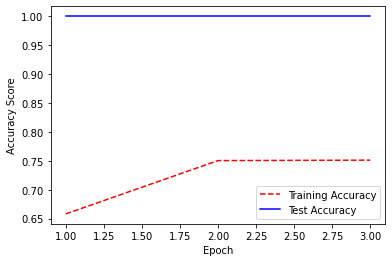

['Altbier']


In [16]:
from src.models.pytorch import train_classification, test_classification

rate = 0.00001
neus = 256

model = train_model(lr=rate, neus=neus)

In [20]:
obs = {
        'review_aroma': [33],
        'review_appearance': [18],
        'review_palate': [46],
        'review_taste': [1]
    }

obsc = sc.transform(pd.DataFrame(obs))

device = get_device()
obst = torch.from_numpy(obsc).float().to(device)

pred = model(obst)
pred = pred.argmax(1).tolist()
enc.inverse_transform(pred)

print(pred)
print(enc.inverse_transform(pred))

[0]
['American IPA']
